In [2]:
import sys
sys.path.append("../..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import nbinom, norm, poisson, rv_continuous

from deep_uncertainty.evaluation.calibration import compute_continuous_ece
from deep_uncertainty.random_variables import DoublePoisson

plt.rcParams['figure.dpi'] = 175

/Users/porterjenkins/opt/anaconda3/envs/deep-uncertainty/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch

In [5]:
device = torch.device('cpu')

## Helper Functions

In [6]:
def plot_posterior_predictive(
    x: np.ndarray,
    y: np.ndarray,
    mu: np.ndarray,
    upper: np.ndarray,
    lower: np.ndarray,
    error_color: str = "r",
    error_alpha: float = 0.2,
    show: bool = True,
    title: str = "",
    ax: plt.Axes | None = None,
):
    """Visualize a model's posterior predictive distribution over a 1d dataset (`x`, `y` both scalars) by showing the expected value and error bounds across the regression targets.

    Args:
        x (np.ndarray): The x values (inputs).
        y (np.ndarray): The ground truth y values (outputs).
        mu (np.ndarray): The expected values of the model's posterior predictive distribution over `y`.
        upper (np.ndarray): Upper bounds for the model's posterior predictive distribution over `y`.
        lower (np.ndarray): Lower bounds for the model's posterior predictive distribution over `y`.
        error_color (str, optional): Color with which to fill the model's error bounds. Defaults to "r".
        alpha (float, optional): Transparency value for the model's error bounds. Defaults to 0.2.
        show (bool, optional): Whether/not to show the resultant plot. Defaults to True.
        title (str, optional): If specified, a title for the resultant plot. Defaults to "".
        ax (plt.Axes | None, optional): If given, the axis on which to plot the posterior predictive distribution. Defaults to None (axis is created).
    """
    order = x.argsort()

    ax = plt.subplots(1, 1, figsize=(10, 6))[1] if ax is None else ax

    ax.scatter(x[order], y[order], alpha=0.1, label="Test Data", s=3)
    ax.plot(x[order], mu[order])
    ax.fill_between(
        x[order], lower[order], upper[order], color=error_color, alpha=error_alpha, label="95% CI"
    )
    ax.set_title(title)
    ax.set_ylim(y.min() - 5, y.max() + 5)
    ax.set_xticks([])
    ax.set_yticks([])
    if show:
        plt.show()

In [7]:
def plot_regression_calibration_curve_cdf(
    y_true: np.ndarray,
    posterior_predictive: rv_continuous,
    num_bins: int = 9,
    ax: plt.Axes | None = None,
    show: bool = True,
):
    """Given targets and a probabilistic regression model (represented as a continuous random variable over the targets), plot a calibration curve.

    Args:
        y_true (ndarray, (n,)): The true values of the regression targets.
        posterior_predictive (rv_continuous): Random variable representing the posterior predictive distribution over the targets.
        num_bins (int): Specifies how many probability thresholds to use for checking CDF calibration. This
                        corresponds to how many points will be plotted to form the calibration curve.
        ax (plt.Axes | None): The axis to plot on (if provided). If None is passed in, an axis is created.
        show (bool): Specifies whether/not to display the resultant plot.
    """
    epsilon = 1e-4
    p_vals = np.linspace(0 + epsilon, 1 - epsilon, num=num_bins).reshape(-1, 1)
    expected_pct_where_cdf_less_than_p = p_vals
    actual_pct_where_cdf_less_than_p = (posterior_predictive.cdf(y_true) <= p_vals).mean(axis=1)

    ece = compute_continuous_ece(y_true, posterior_predictive, num_bins=50, weights="frequency", alpha=1)

    ax = plt.subplots(1, 1)[1] if ax is None else ax
    ax.plot(
        expected_pct_where_cdf_less_than_p,
        expected_pct_where_cdf_less_than_p,
        linestyle="--",
        color="red",
        label="Perfectly calibrated",
    )
    ax.plot(
        expected_pct_where_cdf_less_than_p,
        actual_pct_where_cdf_less_than_p,
        marker="o",
        linestyle="-",
        color="black",
        label="Model",
        markersize=3,
    )
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.annotate(f"ECE: {ece:2f}", xy=(-0.05, 0.9), fontsize=6)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    if show:
        plt.show()

In [8]:
def MMD(x, y, kernel='multiscale'):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

       the default kernel is set as multi-scale

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    # x:(20, 2), x.t:(2, 20) ==> torch.mm(x, x.t) = (20, 20)
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz  # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a ** 2 * (a ** 2 + dxx) ** -1
            YY += a ** 2 * (a ** 2 + dyy) ** -1
            XY += a ** 2 * (a ** 2 + dxy) ** -1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5 * dxx / a)
            YY += torch.exp(-0.5 * dyy / a)
            XY += torch.exp(-0.5 * dxy / a)

    return torch.mean(XX + YY - 2. * XY)

## Generate Data

In [9]:
num_samples = 10000
cont_x = np.random.uniform(1, 10, size=num_samples)
gaussian_y = norm.rvs(loc=cont_x, scale=cont_x/5)
poisson_y = poisson.rvs(mu=cont_x)
double_poisson_y = np.array([DoublePoisson(x_i, 3).rvs(1) for x_i in cont_x]).astype(int)
nbinom_y = nbinom.rvs(n=(4*cont_x).round(), p=0.8)

## Calibrated/Miscalibrated Predictive Distributions

In [10]:
# Well-calibrated

mu_hat = cont_x; sigma_hat = cont_x/5
gaussian_post_pred = norm(loc=mu_hat, scale=sigma_hat)

lambda_hat = cont_x
poisson_post_pred = poisson(mu=lambda_hat)

dpo_mu_hat = cont_x
phi_hat = 3
dpo_post_pred = DoublePoisson(dpo_mu_hat, phi_hat)

n_hat = (4*cont_x).round()
p_hat = 0.8
nbinom_post_pred = nbinom(n=n_hat, p=p_hat)
nbinom_mu_hat = nbinom_post_pred.mean()

# Poorly-calibrated

bad_mu_hat = cont_x + 5
bad_sigma_hat = cont_x / 20
bad_gaussian_post_pred = norm(loc=bad_mu_hat, scale=bad_sigma_hat)

bad_lambda_hat = cont_x + 10
bad_poisson_post_pred = poisson(mu=bad_lambda_hat)

bad_dpo_mu_hat = cont_x + 5
bad_phi_hat = 30
bad_dpo_post_pred = DoublePoisson(bad_dpo_mu_hat, bad_phi_hat)

bad_n_hat = (2*cont_x).round()
bad_p_hat = 0.3
bad_nbinom_post_pred = nbinom(n=bad_n_hat, p=bad_p_hat)

## Create Figure

/var/folders/w5/203pqh9x1h5089n8fqdq8j3w0000gn/T/ipykernel_28684/3250374682.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


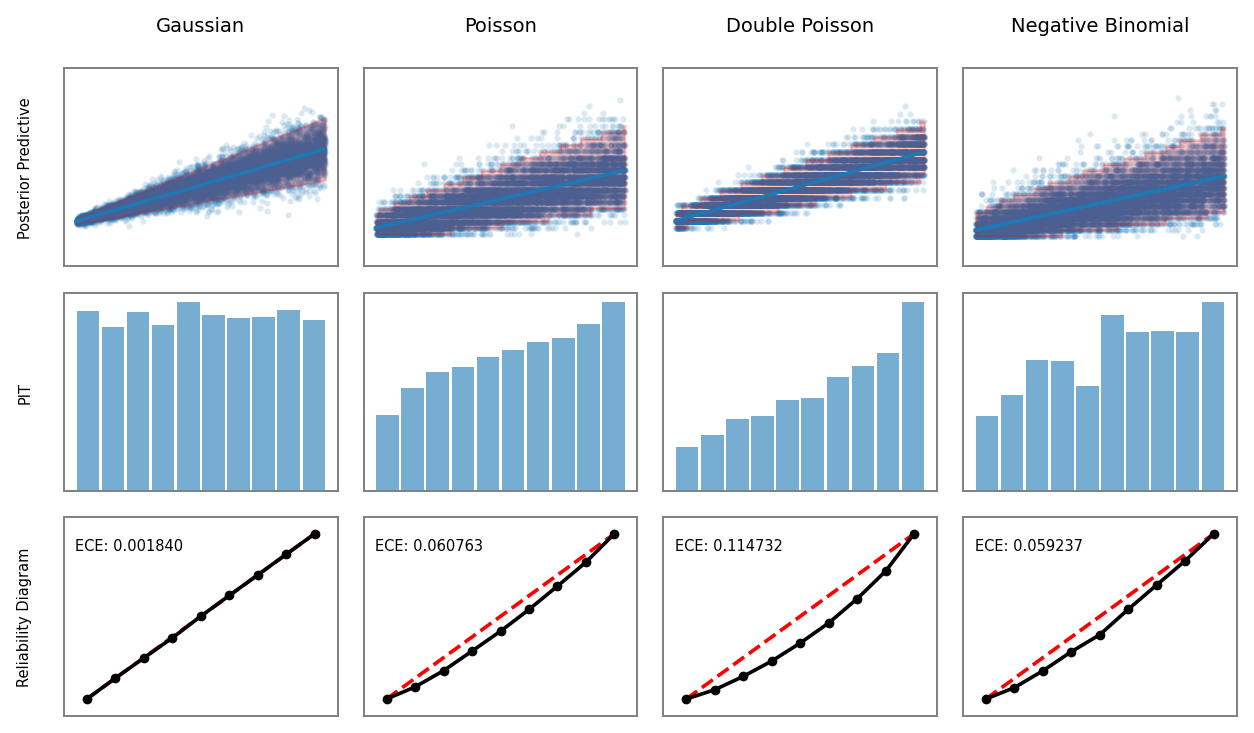

In [55]:
fig, axs = plt.subplots(3, 4, figsize=(7, 4))
title_size = 8
hist_alpha = 0.6
hist_rwidth = 0.9

plot_posterior_predictive(cont_x, gaussian_y, mu_hat, *gaussian_post_pred.ppf([[0.025], [0.975]]), ax=axs[0, 0], show=False)
axs[1, 0].hist(gaussian_post_pred.cdf(gaussian_y), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
plot_regression_calibration_curve_cdf(gaussian_y, gaussian_post_pred, ax=axs[2, 0], show=False)

plot_posterior_predictive(cont_x, poisson_y, lambda_hat, *poisson_post_pred.ppf([[0.025], [0.975]]), ax=axs[0, 1], show=False)
axs[1, 1].hist(poisson_post_pred.cdf(poisson_y), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
plot_regression_calibration_curve_cdf(poisson_y, poisson_post_pred, ax=axs[2, 1], show=False)

plot_posterior_predictive(cont_x, double_poisson_y, dpo_mu_hat, dpo_post_pred.ppf(0.025), dpo_post_pred.ppf(0.975), ax=axs[0, 2], show=False)
axs[1, 2].hist(dpo_post_pred.cdf(double_poisson_y.reshape(-1, 1).flatten()), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])
plot_regression_calibration_curve_cdf(double_poisson_y.flatten(), dpo_post_pred, ax=axs[2, 2], show=False)

plot_posterior_predictive(cont_x, nbinom_y, nbinom_mu_hat, nbinom_post_pred.ppf(0.025), nbinom_post_pred.ppf(0.975), ax=axs[0, 3], show=False)
axs[1, 3].hist(nbinom_post_pred.cdf(nbinom_y), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
plot_regression_calibration_curve_cdf(nbinom_y, nbinom_post_pred, ax=axs[2, 3], show=False)

row_labels = ["Posterior Predictive", "PIT", "Reliability Diagram"]
for ax, row in zip(axs[:, 0], row_labels):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=6, ha='right', va='center', rotation=90)
    

col_labels = ["Gaussian", "Poisson", "Double Poisson", "Negative Binomial"]
for ax, col in zip(axs[0, :], col_labels):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 15),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=8, ha='center', va='baseline')
    
for ax in axs.ravel():
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

plt.show()

## Calculate MMD on Calibrated Predictions

In [61]:
kernel = 'rbf'

### Gaussian MMD

In [62]:
# properly specified
y_pred = gaussian_post_pred.rvs(size=10000)
p = torch.Tensor(gaussian_y.reshape(-1, 1))
q = torch.Tensor(y_pred.reshape(-1, 1))
MMD(x=p, y=q, kernel=kernel)

tensor(2.6136e-06)

In [63]:
# improperly specified
y_pred_bad = bad_gaussian_post_pred.rvs(size=10000)
q = torch.Tensor(y_pred_bad.reshape(-1, 1))
MMD(x=p, y=q, kernel=kernel)

tensor(1.7138)

### Poisson MMD

In [64]:
# Properly specified
y_pred = poisson_post_pred.rvs(size=10000)
p = torch.Tensor(poisson_y.reshape(-1, 1))
q = torch.Tensor(y_pred.reshape(-1, 1))
MMD(x=p, y=q, kernel=kernel)

tensor(0.0001)

In [65]:
# improperly specified
y_pred_bad = bad_poisson_post_pred.rvs(size=10000)
p = torch.Tensor(poisson_y.reshape(-1, 1))
q = torch.Tensor(y_pred_bad.reshape(-1, 1))
MMD(x=p, y=q, kernel=kernel)

tensor(2.8504)

### Negative Binomial MMD

In [66]:
# Properly specified
y_pred = nbinom_post_pred.rvs(size=10000)
p = torch.Tensor(nbinom_y.reshape(-1, 1))
q = torch.Tensor(y_pred.reshape(-1, 1))
MMD(x=p, y=q, kernel=kernel)

tensor(3.6520e-05)

In [67]:
# improperly specified
y_pred_bad = bad_nbinom_post_pred.rvs(size=10000)
p = torch.Tensor(nbinom_y.reshape(-1, 1))
q = torch.Tensor(y_pred_bad.reshape(-1, 1))
MMD(x=p, y=q, kernel=kernel)

tensor(2.0232)

In [36]:
y_pred_bad.shape

(10000,)

## Double Poisson

In [48]:
dpo_post_pred.rvs((1, 10000))

array([[7., 2., 8., ..., 4., 9., 5.]])

In [70]:
# Properly specified
y_pred = dpo_post_pred.rvs((1, 10000)).transpose()
p = torch.Tensor(double_poisson_y.reshape(-1, 1))
q = torch.Tensor(y_pred)
MMD(x=p, y=q, kernel=kernel)

tensor(0.0246)

In [71]:
# improperly specified
y_pred_bad = bad_dpo_post_pred.rvs((1, 10000)).transpose()
p = torch.Tensor(double_poisson_y.reshape(-1, 1))
q = torch.Tensor(y_pred_bad.reshape(-1, 1))
MMD(x=p, y=q, kernel=kernel)

tensor(1.5046)